# **Phishing Emails Detection Using NLP and ML**

# Libraries

**Data Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**NLP Text Libraries**

In [2]:
import string
import re
import nltk
import nltk.corpus
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

[nltk_data] Error loading punkt: HTTP Error 503: Backend is unhealthy
[nltk_data] Error loading stopwords: HTTP Error 503: Backend is
[nltk_data]     unhealthy
[nltk_data] Error loading wordnet: HTTP Error 503: Backend is
[nltk_data]     unhealthy


**EDA Analysis**

In [3]:
# Text Polarity
from textblob import TextBlob

# Text Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Word Cloud
from wordcloud import WordCloud

**Model Selection and Evaluation**

In [4]:
# Model Building
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Model Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report



---



# The Dataset

**Read The Dataset**

*Cambridge Dataset Years (2011 to 2018)*

*Nazario Dataset Years (2011 to 2022)*


In [5]:
# 1. Enron Legitimate Emails Dataset
# Load and Process Data
enron_df = pd.read_excel(r'C:\Users\Gaurav Narkhede\Desktop\Final_code\Dataset\Enron\Extracted data\enron_data.xlsx')

# Shape of dataframe
print(" Shape of Enron dataframe: ", enron_df.shape)

# Drop duplicates
enron_df = enron_df.drop_duplicates()
print(" Shape of Enron dataframe after dropping duplicates: ", enron_df.shape)

# Replace Blank Values with NAN
enron_df = enron_df.apply(lambda x: x.str.strip()).replace('', np.nan)

# Checking Null Values
enron_df.isnull().sum()

# Drop rows with NaN values in either 'subject' or 'body' columns
enron_df.dropna(subset=['subject', 'body'], inplace=True)

# Display the shape of the dataframe after dropping NaN values
enron_df.shape


 Shape of Enron dataframe:  (517401, 2)
 Shape of Enron dataframe after dropping duplicates:  (250094, 2)


(240693, 2)

In [6]:
# 2. Cambridge Phishing Emails Dataset
# List of filenames
cambridge_files = [
    r"C:\Users\Gaurav Narkhede\Desktop\Final_code\Dataset\Cambridge\Extracted data/data2011_to_2014.xlsx",
    r"C:\Users\Gaurav Narkhede\Desktop\Final_code\Dataset\Cambridge\Extracted data/data2015.xlsx",
    r"C:\Users\Gaurav Narkhede\Desktop\Final_code\Dataset\Cambridge\Extracted data/data2016.xlsx",
    r"C:\Users\Gaurav Narkhede\Desktop\Final_code\Dataset\Cambridge\Extracted data/data2017.xlsx",
    r"C:\Users\Gaurav Narkhede\Desktop\Final_code\Dataset\Cambridge\Extracted data/data2018.xlsx"
]

# Load each Excel file into a list of DataFrames
cambridge_data = [pd.read_excel(filename) for filename in cambridge_files]

# Concatenate all DataFrames into a single DataFrame
cambridge_df = pd.concat(cambridge_data, ignore_index=True)


# Shape of dataframe
print(" Shape of Cambridge dataframe: ", cambridge_df.shape)

# Drop duplicates
cambridge_df = cambridge_df.drop_duplicates()
print(" Shape of Cambridge dataframe after dropping duplicates: ", cambridge_df.shape)

# Replace Blank Values with NAN
cambridge_df = cambridge_df.apply(lambda x: x.str.strip()).replace('', np.nan)

# Checking Null Values
cambridge_df.isnull().sum()

# Drop rows with NaN values in either 'subject' or 'body' columns
cambridge_df.dropna(subset=['subject', 'body'], inplace=True)

# Display the shape of the dataframe after dropping NaN values
cambridge_df.shape


 Shape of Cambridge dataframe:  (12896, 2)
 Shape of Cambridge dataframe after dropping duplicates:  (6931, 2)


(6672, 2)

In [7]:
# 3. Nazario Phishing Emails Dataset
# Load and Process Data
nazario_df = pd.read_excel(r"C:\Users\Gaurav Narkhede\Desktop\Final_code\Dataset\nazario\Extracted data\nazario_recent.xlsx")

# Shape of dataframe
print(" Shape of Nazario dataframe: ", nazario_df.shape)

# Drop duplicates
nazario_df = nazario_df.drop_duplicates()
print(" Shape of Nazario dataframe after dropping duplicates: ", nazario_df.shape)

# Replace Blank Values with NAN
nazario_df = nazario_df.apply(lambda x: x.str.strip()).replace('', np.nan)

# Checking Null Values
nazario_df.isnull().sum()

# Drop rows with NaN values in either 'subject' or 'body' columns
nazario_df.dropna(subset=['subject', 'body'], inplace=True)

# Display the shape of the dataframe after dropping NaN values
nazario_df.shape


 Shape of Nazario dataframe:  (2163, 2)
 Shape of Nazario dataframe after dropping duplicates:  (2012, 2)


(1853, 2)

# Data Preprocessing

In [8]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Replace email addresses in the text with a placeholder.
def replace_email(input_string, replacement_string='<emailaddress>'):
    output_string = re.sub(r'\b[A-Za-z0-9._%+-]+@([A-Za-z0-9.-]+\.[A-Z|a-z]{2,})\b', replacement_string, input_string)
    return output_string

# Replace URLs in the text with a placeholder.
def replace_url(input_string, replacement_string='<urladdress>'):
    output_string = re.sub(r'((http|ftp|https)\:\/\/)?([\w_\.-]+(?:\.(zw|zuerich|zone|...|com|org|net)...))([\w.,?^=%&@:/~+#-]*[\w?^=%&@/~+#-])?', replacement_string, input_string)
    return output_string

# Remove stopwords from the text.
def remove_stopwords(input_text):
    stop_words = set(stopwords.words('english'))
    words = input_text.split()
    clean_list = [word for word in words if word.lower() not in stop_words]
    return ' '.join(clean_list)

# Lemmatize the words using the WordNet lemmatizer.
def lemmatize(input_text):
    lemmatizer = WordNetLemmatizer()
    words = input_text.split()
    lemmatized_list = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_list)

# Clean up any stray whitespace or periods.
def sanitize_whitespace(input_string):
    lines = input_string.split('\n')
    for index, line in enumerate(lines):
        if line == '.':
            lines.remove(line)
            for i in range(1, len(lines)):
                if (lines[index-i] != ''):
                    lines[index-i] += '.'
                    break
    output_string = '\n'.join(lines)
    return output_string.strip()

# Clean the column using various substitutions and removals.
def clean_column(data):
    # Specific replacements
    data = re.sub(r"\'ve", " have ", data)
    data = re.sub(r"can't", "cannot ", data)
    data = re.sub(r"n't", " not ", data)
    data = re.sub(r"I'm", "I am", data)
    data = re.sub(r" m ", " am ", data)
    data = re.sub(r"\'re", " are ", data)
    data = re.sub(r"\'d", " would ", data)
    data = re.sub(r"\'ll", " will ", data)
    
    # Remove digits
    data = re.sub(r'\d', '', data)
    
    # If 'forwarded by:' exists, take only content after 'subject'
    if 'forwarded by:' in data:
        data = data.split('subject')[1]
    
    return data.strip()

# Main preprocessing function that integrates all the above steps.
def preprocess_text(input_text):
    text = replace_email(input_text)
    text = replace_url(text)
    text = clean_column(text)
    text = remove_stopwords(text)
    lemmatized_text = lemmatize(text)
    text = sanitize_whitespace(lemmatized_text)
    return text


In [9]:
enron_df_new = pd.DataFrame()

enron_df_new['subject'] = enron_df['subject'].apply(preprocess_text)
enron_df_new['body'] = enron_df['body'].apply(preprocess_text)


legitimate_df = enron_df_new.sample(n=10000, random_state=42)

legitimate_df['label'] = 0
legitimate_df.head()

,subject,body,label
462053,Re: deal # .,"Sierra Power <urladdress> it. Thanks, kate Mel...",0
86152,RE:,()- give time know do-I sure want mess much tr...,0
23970,Wellesley Revised Strategy,Hello Team!!! Due scheduling conflict strategy...,0
145903,Start Date: //; HourAhead hour: ; <CODESITE>,Start Date: //; HourAhead hour: ; ancillary sc...,0
127910,Management Changes,To: Enron Employees From: Office Chief Executi...,0


In [10]:
cambridge_df_new = pd.DataFrame()

cambridge_df_new['subject'] = cambridge_df['subject'].apply(preprocess_text)
cambridge_df_new['body'] = cambridge_df['body'].apply(preprocess_text)
cambridge_df_new.head()

,subject,body
0,Account Ownership Validation. ==,Egg Internet Banking Account Ownership Validat...
1,"Ihre Kreditkarte wurde ausgesetzt, weil wir ei...","Sehr geehrter Kunde, Wir informieren Sie, das ..."
2,Online Services: eligible receive tax refund.==,MBNA Online Services last annual calculation f...
3,Halifax Online Service Team Notification.===,Online Service Team Account Notification take ...
4,Tax Refund Notification=,Tax Refund Notification last annual calculatio...


In [11]:
nazario_df_new = pd.DataFrame()

nazario_df_new['subject'] = nazario_df['subject'].apply(preprocess_text)
nazario_df_new['body'] = nazario_df['body'].apply(preprocess_text)
nazario_df_new.head()

,subject,body
0,DELETE MESSAGE -- FOLDER INTERNAL DATA,"text part internal format mail folder, real <u..."
1,Important Security Update,"<<urladdress>> Dear Customer, received email b..."
3,Important Security Update,"Dear Customer, received email strong believe a..."
4,Important Security Update,"Dear Customer, received email strong believe a..."
5,Bank America Alert: Online Account Locked,<<urladdress>>


In [12]:
# merged 
phishing_df = pd.concat([cambridge_df_new, nazario_df_new], ignore_index=True)

phishing_df['label'] = 1


dataset = pd.concat([legitimate_df, phishing_df], ignore_index=True)
dataset.head()


,subject,body,label
0,Re: deal # .,"Sierra Power <urladdress> it. Thanks, kate Mel...",0
1,RE:,()- give time know do-I sure want mess much tr...,0
2,Wellesley Revised Strategy,Hello Team!!! Due scheduling conflict strategy...,0
3,Start Date: //; HourAhead hour: ; <CODESITE>,Start Date: //; HourAhead hour: ; ancillary sc...,0
4,Management Changes,To: Enron Employees From: Office Chief Executi...,0


In [27]:
dataset.to_excel('final_dataset.xlsx')

**Statistic Description of The Dataset**

In [13]:
dataset.describe(include = "all")

,subject,body,label
count,18525,18525,18525.000000
unique,14455,16797,NaN
top,RE:,Start Date: //; HourAhead hour: ; ancillary sc...,NaN
freq,208,51,NaN
mean,NaN,NaN,0.460189
std,NaN,NaN,0.498426
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,1.000000


**Class Proportion**

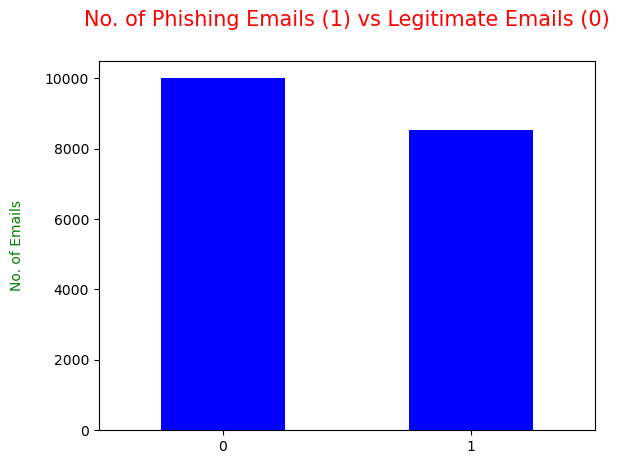

In [14]:
dataset["label"].value_counts().plot(kind = "bar", color = "blue")
plt.title("No. of Phishing Emails (1) vs Legitimate Emails (0)", loc = "center", fontsize = 15, color = "red", pad = 25)
plt.xticks(rotation = 0)
plt.ylabel("No. of Emails", color = "green", fontsize = 10, labelpad = 15)
plt.show()

In [15]:
# Sentiment Analysis
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Sentiment analysis functions
def get_sentiment(text):
    return sia.polarity_scores(str(text))['compound']

def classify_sentiment(score):
    threshold = 0.05
    if score > threshold:
        return 'Positive'
    elif score < -threshold:
        return 'Negative'
    else:
        return 'Neutral'

# Keywords for emotional themes
urgency_keywords = ["urgent", "immediately", "as soon as possible", "asap", "now", "act now", "important", "time-sensitive"]
fear_keywords = ["suspension", "blocked", "penalty", "warning", "alert", "suspended"]
positive_keywords = ["reward", "bonus", "offer", "win", "prize", "congratulations", "free", "discount"]

def contains_keywords(text, keywords):
    text = str(text)  # Convert to string
    return any(word in text.lower() for word in keywords)

# Functions to determine the presence of each emotional theme
def detect_emotional_urgency(text):
    sentiment = classify_sentiment(get_sentiment(text))
    if sentiment in ["Positive", "Negative"] and contains_keywords(text, urgency_keywords):
        return 1
    return 0

def detect_fear_appeal(text):
    sentiment = classify_sentiment(get_sentiment(text))
    if sentiment == "Negative" and contains_keywords(text, fear_keywords):
        return 1
    return 0

def detect_positive_reinforcement(text):
    sentiment = classify_sentiment(get_sentiment(text))
    if sentiment == "Positive" and contains_keywords(text, positive_keywords):
        return 1
    return 0

# Analyzing sentiments
#dataset['subject_sentiment'] = dataset['subject'].apply(get_sentiment).apply(classify_sentiment)
#dataset['body_sentiment'] = dataset['body'].apply(get_sentiment).apply(classify_sentiment)

# Generating emotional themes columns
dataset['subject_emotional_urgency'] = dataset['subject'].apply(detect_emotional_urgency)
dataset['body_emotional_urgency'] = dataset['body'].apply(detect_emotional_urgency)
dataset['subject_fear_appeal'] = dataset['subject'].apply(detect_fear_appeal)
dataset['body_fear_appeal'] = dataset['body'].apply(detect_fear_appeal)
dataset['subject_positive_reinforcement'] = dataset['subject'].apply(detect_positive_reinforcement)
dataset['body_positive_reinforcement'] = dataset['body'].apply(detect_positive_reinforcement)

dataset.head()

,subject,body,label,subject_emotional_urgency,body_emotional_urgency,subject_fear_appeal,body_fear_appeal,subject_positive_reinforcement,body_positive_reinforcement
0,Re: deal # .,"Sierra Power <urladdress> it. Thanks, kate Mel...",0,0,0,0,0,0,0
1,RE:,()- give time know do-I sure want mess much tr...,0,0,1,0,0,0,1
2,Wellesley Revised Strategy,Hello Team!!! Due scheduling conflict strategy...,0,0,0,0,0,0,1
3,Start Date: //; HourAhead hour: ; <CODESITE>,Start Date: //; HourAhead hour: ; ancillary sc...,0,0,0,0,0,0,0
4,Management Changes,To: Enron Employees From: Office Chief Executi...,0,0,1,0,0,0,0


In [16]:
# Readability
import textstat

# Compute Flesch Reading Ease for each email and store in a new column
dataset['Flesch_Reading_Ease'] = dataset['body'].apply(lambda x: textstat.flesch_reading_ease(str(x)))

# Compute Gunning Fog Index for each email and store in a new column
dataset['Gunning_Fog_Index'] = dataset['body'].apply(lambda x: textstat.gunning_fog(str(x)))

# Compute SMOG Index for each email and store in a new column
dataset['SMOG_Index'] = dataset['body'].apply(lambda x: textstat.smog_index(str(x)))

# Compute Automated Readability Index (ARI) for each email and store in a new column
dataset['Automated_Readability_Index'] = dataset['body'].apply(lambda x: textstat.automated_readability_index(str(x)))

dataset.head()

,subject,body,label,subject_emotional_urgency,body_emotional_urgency,subject_fear_appeal,body_fear_appeal,subject_positive_reinforcement,body_positive_reinforcement,Flesch_Reading_Ease,Gunning_Fog_Index,SMOG_Index,Automated_Readability_Index
0,Re: deal # .,"Sierra Power <urladdress> it. Thanks, kate Mel...",0,0,0,0,0,0,0,36.66,9.43,11.9,16.9
1,RE:,()- give time know do-I sure want mess much tr...,0,0,1,0,0,0,1,73.47,7.70,8.8,14.6
2,Wellesley Revised Strategy,Hello Team!!! Due scheduling conflict strategy...,0,0,0,0,0,0,1,34.63,10.40,11.2,17.5
3,Start Date: //; HourAhead hour: ; <CODESITE>,Start Date: //; HourAhead hour: ; ancillary sc...,0,0,0,0,0,0,0,29.01,12.81,0.0,27.4
4,Management Changes,To: Enron Employees From: Office Chief Executi...,0,0,1,0,0,0,0,10.70,15.63,17.1,20.2


In [17]:
# Semantic Analysis
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    # Check if the input is a string; if not, return an empty list
    if not isinstance(text, str):
        return []
    
    # Remove stopwords
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    return tokens



from gensim.models import Word2Vec

# Preprocess the data
subjects = dataset['subject'].apply(preprocess_text)
bodies = dataset['body'].apply(preprocess_text)
all_texts = subjects + bodies

# Train Word2Vec model
model = Word2Vec(sentences=all_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec_model.model")

def get_average_word2vec(tokens_list, model, generate_missing=False, k=100):
    if not isinstance(tokens_list, list):  # Check if tokens_list is a list
        tokens_list = []
    
    vectorized = []
    for word in tokens_list:
        try:
            vec = model.wv[word]  # Accessing word vectors using model.wv
            vectorized.append(vec)
        except KeyError:  # Word not in the model's vocabulary
            if generate_missing:
                vectorized.append(np.random.rand(k))
            else:
                vectorized.append(np.zeros(k))
    
    length = len(vectorized)
    if length == 0:  # Handle case where tokens_list might be empty
        return np.zeros(k)
    
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged


dataset['subject_vector'] = dataset['subject'].apply(lambda x: get_average_word2vec(x, model))
dataset['body_vector'] = dataset['body'].apply(lambda x: get_average_word2vec(x, model))
dataset.head()

,subject,body,label,subject_emotional_urgency,body_emotional_urgency,subject_fear_appeal,body_fear_appeal,subject_positive_reinforcement,body_positive_reinforcement,Flesch_Reading_Ease,Gunning_Fog_Index,SMOG_Index,Automated_Readability_Index,subject_vector,body_vector
0,Re: deal # .,"Sierra Power <urladdress> it. Thanks, kate Mel...",0,0,0,0,0,0,0,36.66,9.43,11.9,16.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,RE:,()- give time know do-I sure want mess much tr...,0,0,1,0,0,0,1,73.47,7.70,8.8,14.6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Wellesley Revised Strategy,Hello Team!!! Due scheduling conflict strategy...,0,0,0,0,0,0,1,34.63,10.40,11.2,17.5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Start Date: //; HourAhead hour: ; <CODESITE>,Start Date: //; HourAhead hour: ; ancillary sc...,0,0,0,0,0,0,0,29.01,12.81,0.0,27.4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Management Changes,To: Enron Employees From: Office Chief Executi...,0,0,1,0,0,0,0,10.70,15.63,17.1,20.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
dataset.head()

,subject,body,label,subject_emotional_urgency,body_emotional_urgency,subject_fear_appeal,body_fear_appeal,subject_positive_reinforcement,body_positive_reinforcement,Flesch_Reading_Ease,Gunning_Fog_Index,SMOG_Index,Automated_Readability_Index,subject_vector,body_vector
0,Re: deal # .,"Sierra Power <urladdress> it. Thanks, kate Mel...",0,0,0,0,0,0,0,36.66,9.43,11.9,16.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,RE:,()- give time know do-I sure want mess much tr...,0,0,1,0,0,0,1,73.47,7.70,8.8,14.6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Wellesley Revised Strategy,Hello Team!!! Due scheduling conflict strategy...,0,0,0,0,0,0,1,34.63,10.40,11.2,17.5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Start Date: //; HourAhead hour: ; <CODESITE>,Start Date: //; HourAhead hour: ; ancillary sc...,0,0,0,0,0,0,0,29.01,12.81,0.0,27.4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Management Changes,To: Enron Employees From: Office Chief Executi...,0,0,1,0,0,0,0,10.70,15.63,17.1,20.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [19]:
# Stylometric Features

# Tokenization methods
def tokenize_words(text):
    if not isinstance(text, str):
        return []
    return [word.strip(string.punctuation) for word in text.split()]

def tokenize_sentences(text):
    if not isinstance(text, str):
        return []
    # Split text into sentences based on periods, exclamation points, and question marks
    return [sent.strip() for sent in re.split('[.!?]', text) if sent]

# Function to calculate average word length using tokenization
def average_word_length_alt(text):
    words = tokenize_words(text)
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

# Function to calculate average sentence length using tokenization
def average_sentence_length_alt(text):
    sentences = tokenize_sentences(text)
    if len(sentences) == 0:
        return 0
    return sum(len(sentence.split()) for sentence in sentences) / len(sentences)

# Function to calculate type-token ratio using tokenization
def type_token_ratio_alt(text):
    words = tokenize_words(text)
    if len(words) == 0:
        return 0
    return len(set(words)) / len(words)

# Extract the features using tokenization methods
dataset['avg_word_length'] = dataset['body'].apply(average_word_length_alt)
dataset['avg_sentence_length'] = dataset['body'].apply(average_sentence_length_alt)
dataset['type_token_ratio'] = dataset['body'].apply(type_token_ratio_alt)

# Extract the 'exclamation_count' feature
dataset['exclamation_count'] = dataset['body'].astype(str).str.count('!')
dataset.head()

,subject,body,label,subject_emotional_urgency,body_emotional_urgency,subject_fear_appeal,body_fear_appeal,subject_positive_reinforcement,body_positive_reinforcement,Flesch_Reading_Ease,Gunning_Fog_Index,SMOG_Index,Automated_Readability_Index,subject_vector,body_vector,avg_word_length,avg_sentence_length,type_token_ratio,exclamation_count
0,Re: deal # .,"Sierra Power <urladdress> it. Thanks, kate Mel...",0,0,0,0,0,0,0,36.66,9.43,11.9,16.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.294118,8.250000,0.705882,0
1,RE:,()- give time know do-I sure want mess much tr...,0,0,1,0,0,0,1,73.47,7.70,8.8,14.6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.957447,15.666667,0.872340,0
2,Wellesley Revised Strategy,Hello Team!!! Due scheduling conflict strategy...,0,0,0,0,0,0,1,34.63,10.40,11.2,17.5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6.305556,9.000000,0.916667,3
3,Start Date: //; HourAhead hour: ; <CODESITE>,Start Date: //; HourAhead hour: ; ancillary sc...,0,0,0,0,0,0,0,29.01,12.81,0.0,27.4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.400000,5.250000,0.900000,0
4,Management Changes,To: Enron Employees From: Office Chief Executi...,0,0,1,0,0,0,0,10.70,15.63,17.1,20.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6.326316,18.800000,0.789474,0


In [20]:
# Texual Content Analysis

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Ensure both 'subject' and 'body' columns are treated as strings
dataset['subject'] = dataset['subject'].astype(str)
dataset['body'] = dataset['body'].astype(str)

# Combine subject and body
dataset['processed_content'] = dataset['subject'] + " " + dataset['body']


# 1. Impersonal Greetings

def has_impersonal_greeting_pattern(text):
    patterns = [
        r"dear\s+(?:[\w\s.\®&]+)?\s*customer",
        r"dear\s+(?:[\w\s.\®&]+)?\s*user",
        r"dear\s+(?:[\w\s.\®&]+)?\s*member",
        r"dear\s+(?:[\w\s.\®&]+)?\s*account\s*holder",
        r"dear\s+(?:[\w\s.\®&]+)?\s*valued\s*customer",
        r"dear\s+(?:[\w\s.\®&]+)?\s*client",
        r"dear\s+(?:[\w\s.\®&]+)?\s*account"  
    ]
    for pattern in patterns:
        if re.search(pattern, text, flags=(re.IGNORECASE | re.DOTALL)):
            return True
    return False


dataset['has_impersonal_greeting'] = dataset['processed_content'].apply(has_impersonal_greeting_pattern)
dataset['has_impersonal_greeting'] = dataset['has_impersonal_greeting'].astype(int)



# 2. Phishing Keywords
phishing_keywords = [
    "verify", "update account", "password reset", "click here", "your password has expired", 
    "urgent action required", "suspicious activity detected", "account locked", "account suspension", 
    "security alert", "confirm your identity", "validate your account", "billing information", 
    "payment declined", "secure your account", "account verification", "login from a new device", 
    "failed login attempts", "unauthorized access", "account deactivation", "information update", 
    "claim your refund", "confirm your email", "final notice", "account compromise", "payment issue", 
    "security breach", "view the attachment", "wire transfer", "security update", "change your password", 
    "confirm transaction", "pending payment", "account review"
]
dataset['has_phishing_keywords'] = dataset['processed_content'].apply(lambda x: any(keyword in x.lower() for keyword in phishing_keywords))

# 3. TF-IDF Features
# Convert the processed text data into numerical features using TF-IDF with n-grams
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 3))

# Convert the processed text data into numerical features using TF-IDF with n-grams
processed_text_tfidf = tfidf.fit_transform(dataset['processed_content']).toarray()

dataset.head()

,subject,body,label,subject_emotional_urgency,body_emotional_urgency,subject_fear_appeal,body_fear_appeal,subject_positive_reinforcement,body_positive_reinforcement,Flesch_Reading_Ease,...,Automated_Readability_Index,subject_vector,body_vector,avg_word_length,avg_sentence_length,type_token_ratio,exclamation_count,processed_content,has_impersonal_greeting,has_phishing_keywords
0,Re: deal # .,"Sierra Power <urladdress> it. Thanks, kate Mel...",0,0,0,0,0,0,0,36.66,...,16.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.294118,8.250000,0.705882,0,Re: deal # . Sierra Power <urladdress> it. Tha...,0,False
1,RE:,()- give time know do-I sure want mess much tr...,0,0,1,0,0,0,1,73.47,...,14.6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.957447,15.666667,0.872340,0,RE: ()- give time know do-I sure want mess muc...,0,False
2,Wellesley Revised Strategy,Hello Team!!! Due scheduling conflict strategy...,0,0,0,0,0,0,1,34.63,...,17.5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6.305556,9.000000,0.916667,3,Wellesley Revised Strategy Hello Team!!! Due s...,0,False
3,Start Date: //; HourAhead hour: ; <CODESITE>,Start Date: //; HourAhead hour: ; ancillary sc...,0,0,0,0,0,0,0,29.01,...,27.4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.400000,5.250000,0.900000,0,Start Date: //; HourAhead hour: ; <CODESITE> S...,0,False
4,Management Changes,To: Enron Employees From: Office Chief Executi...,0,0,1,0,0,0,0,10.70,...,20.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6.326316,18.800000,0.789474,0,Management Changes To: Enron Employees From: O...,0,False


In [21]:
# Stack all engineered features together
X_combined = np.hstack([
    processed_text_tfidf,
    dataset['has_impersonal_greeting'].values.reshape(-1, 1),
    dataset['has_phishing_keywords'].values.reshape(-1, 1),
    dataset[['subject_emotional_urgency', 'body_emotional_urgency', 'subject_fear_appeal', 'body_fear_appeal', 'subject_positive_reinforcement', 'body_positive_reinforcement']].values,
    dataset[['Flesch_Reading_Ease', 'Gunning_Fog_Index', 'SMOG_Index', 'Automated_Readability_Index']].values,
    np.array(dataset['subject_vector'].tolist()),
    np.array(dataset['body_vector'].tolist()),
    dataset[['avg_word_length', 'avg_sentence_length', 'type_token_ratio', 'exclamation_count']].values
])


# Assuming X_combined is your feature matrix and dataset['label'] are the labels
X_train, X_test, y_train, y_test = train_test_split(X_combined, dataset['label'], test_size=0.2, random_state=42)


Decision Tree Results:
Accuracy: 0.9643724696356275
Precision: 0.9630292188431724
Recall: 0.9584569732937686
F1 Score: 0.9607376561570494
ROC AUC Score: 0.963881951993419
Log Loss: 1.2305446853357316
--------------------------------------------------


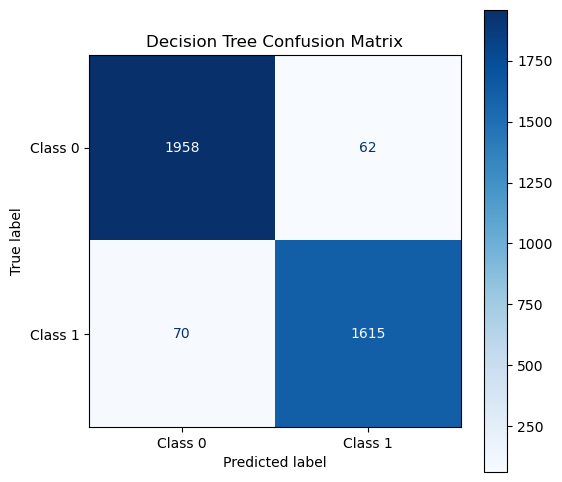

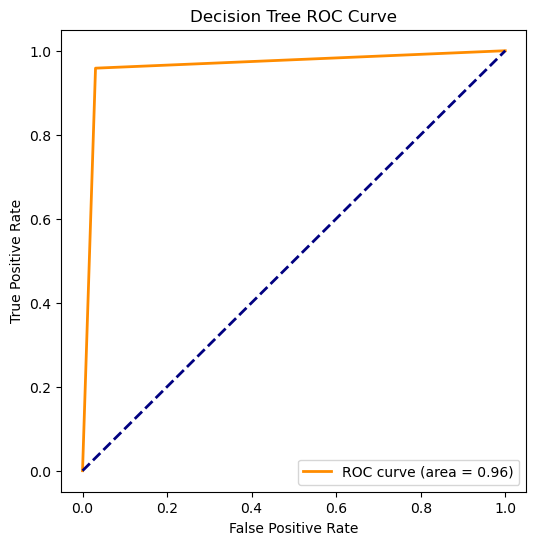

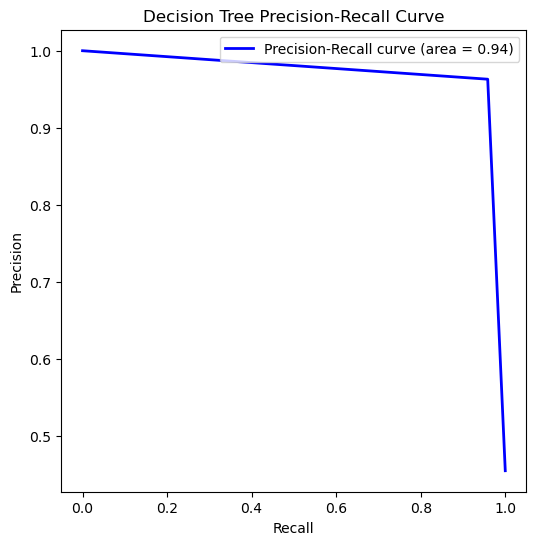

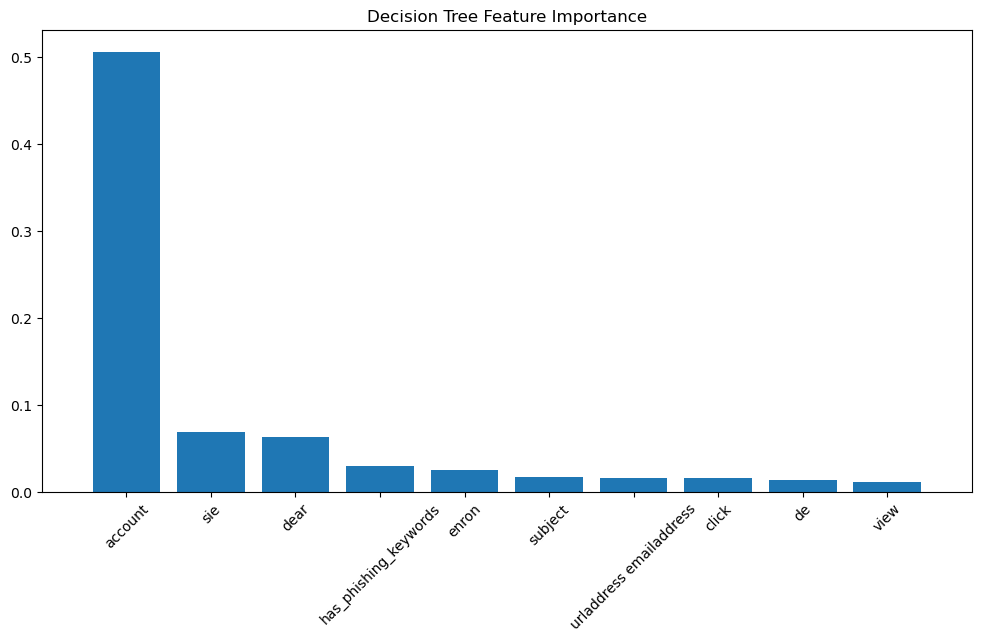

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, log_loss
import matplotlib.pyplot as plt


# Train Decision Tree model
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)
y_prob = dt_classifier.predict_proba(X_test)[:, 1]

print("Decision Tree Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Log Loss:", log_loss(y_test, y_prob))
print("--------------------------------------------------")


# Confusion Matrix Visualization
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(dt_classifier, X_test, y_test, ax=ax, cmap="Blues", display_labels=["Class 0", "Class 1"])
ax.set_title("Decision Tree Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Decision Tree Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

# Feature Importance
# Assuming feature_names is a list of names of your features
feature_names = tfidf.get_feature_names() + ['has_impersonal_greeting', 'has_phishing_keywords']
# More feature names can be appended based on the features you have used.
feature_importance = dt_classifier.feature_importances_
indices = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Decision Tree Feature Importance")
plt.bar(range(10), feature_importance[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45)
plt.xlim([-1, 10])
plt.show()


Random Forest Results:
Accuracy: 0.9854251012145749
Precision: 0.9897897897897898
Recall: 0.9780415430267062
F1 Score: 0.9838805970149254
ROC AUC Score: 0.998214002409143
Log Loss: 0.07667014155573518
--------------------------------------------------


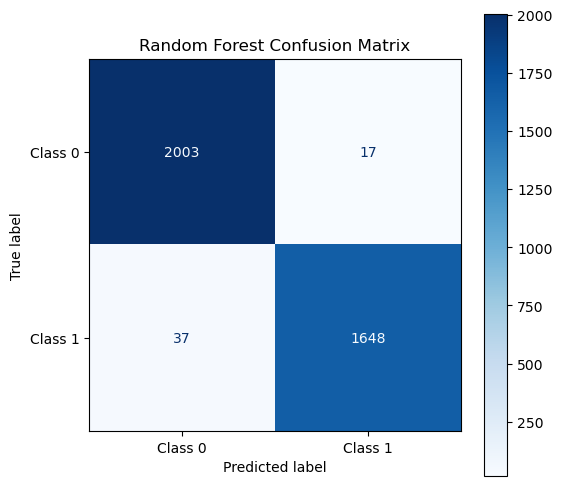

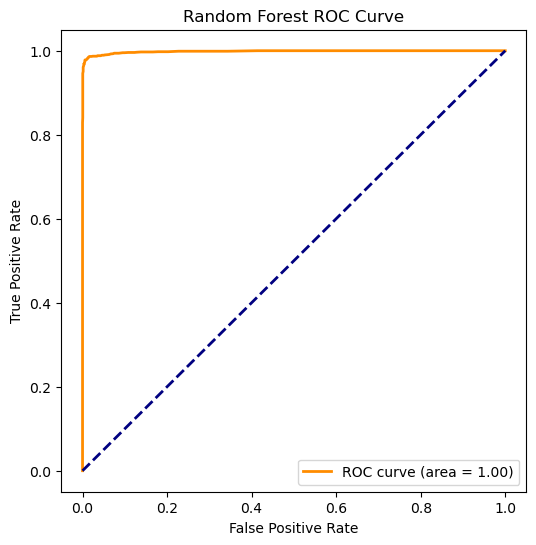

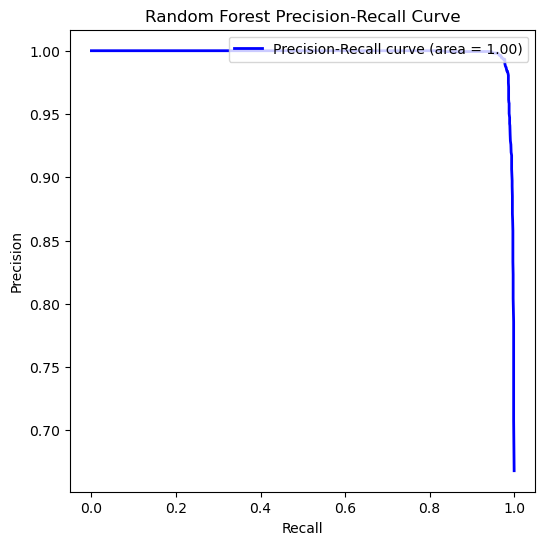

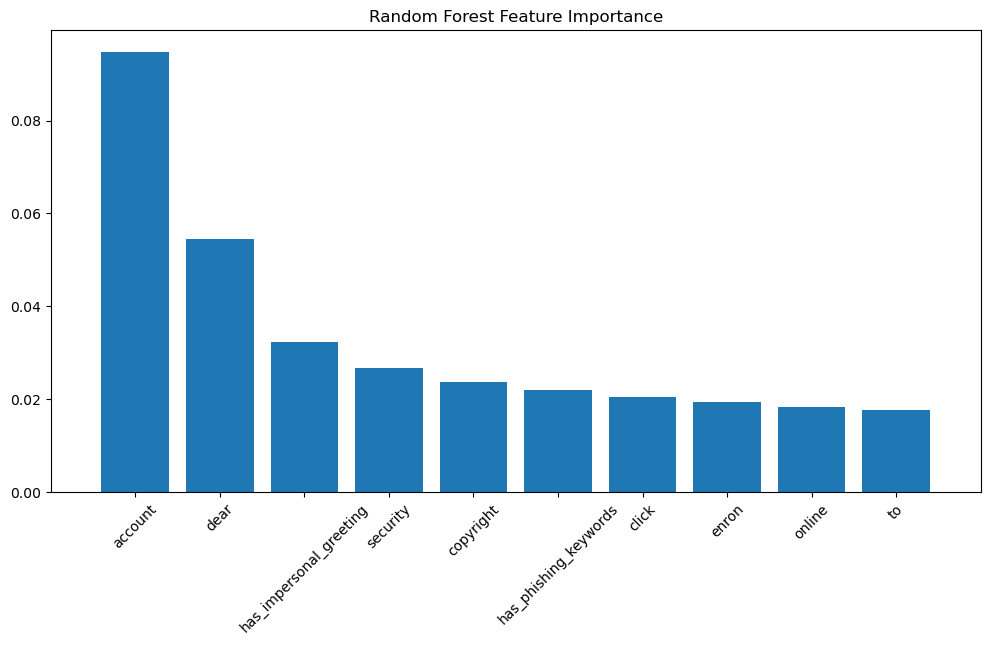

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]

print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Log Loss:", log_loss(y_test, y_prob))
print("--------------------------------------------------")


# Confusion Matrix Visualization
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(rf_classifier, X_test, y_test, ax=ax, cmap="Blues", display_labels=["Class 0", "Class 1"])
ax.set_title("Random Forest Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

# Feature Importance
feature_importance = rf_classifier.feature_importances_
indices = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Random Forest Feature Importance")
plt.bar(range(10), feature_importance[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45)
plt.xlim([-1, 10])
plt.show()


Logistic Regression Results:
Accuracy: 0.9794871794871794
Precision: 0.9866908650937689
Recall: 0.9679525222551929
F1 Score: 0.9772318753744759
ROC AUC Score: 0.9975567764491583
Log Loss: 0.06696558719805598
--------------------------------------------------


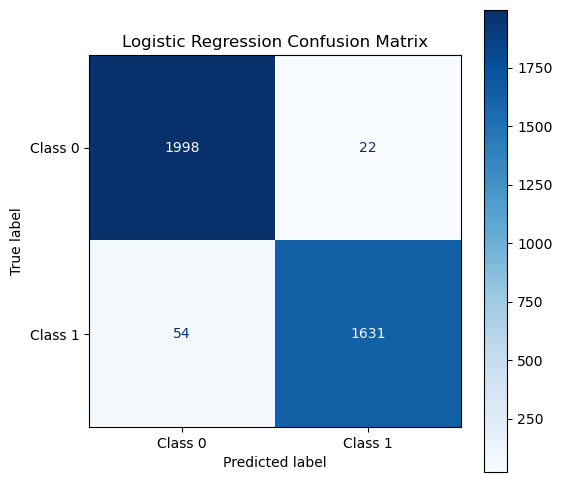

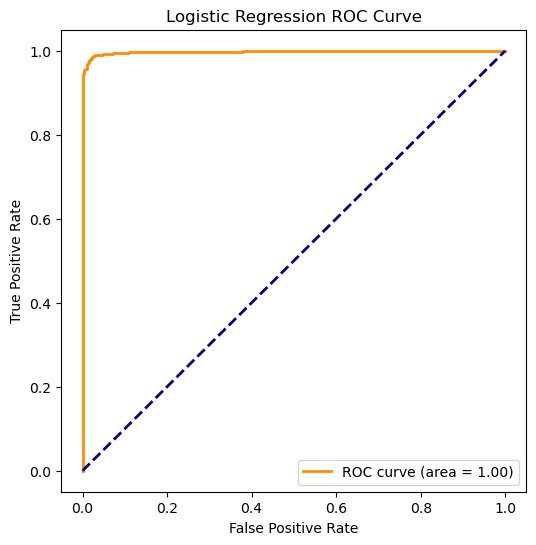

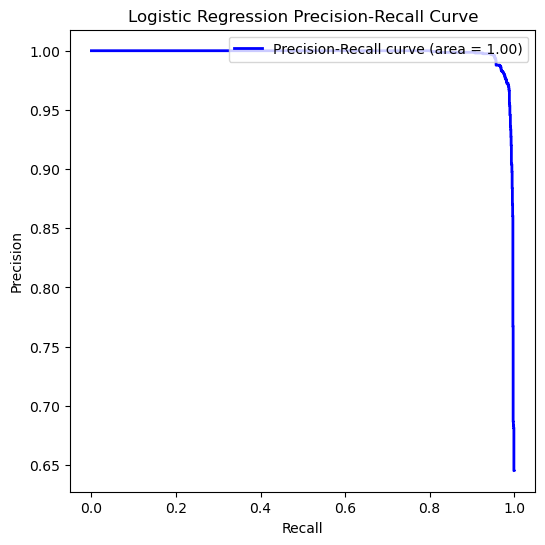

In [24]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model
lr_classifier = LogisticRegression(random_state=42, max_iter=5000)
lr_classifier.fit(X_train, y_train)

# Predictions
y_pred = lr_classifier.predict(X_test)
y_prob = lr_classifier.predict_proba(X_test)[:, 1]

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Log Loss:", log_loss(y_test, y_prob))
print("--------------------------------------------------")


# Confusion Matrix Visualization
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(lr_classifier, X_test, y_test, ax=ax, cmap="Blues", display_labels=["Class 0", "Class 1"])
ax.set_title("Logistic Regression Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic Regression Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


Naive Bayes Results:
Accuracy: 0.9670715249662618
Precision: 0.9637982195845697
Recall: 0.9637982195845697
F1 Score: 0.9637982195845697
ROC AUC Score: 0.973768839791991
Log Loss: 1.1347928617844432
--------------------------------------------------


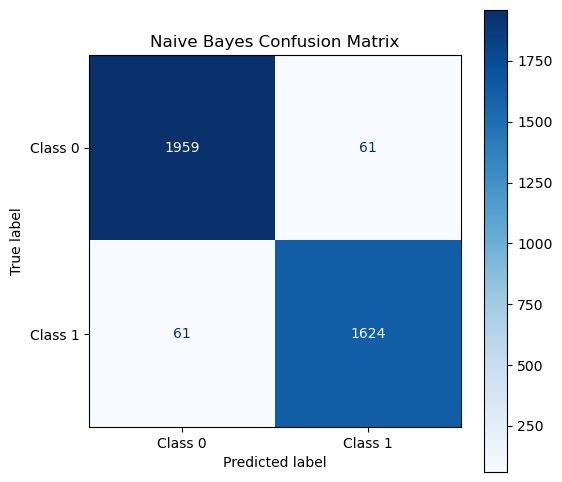

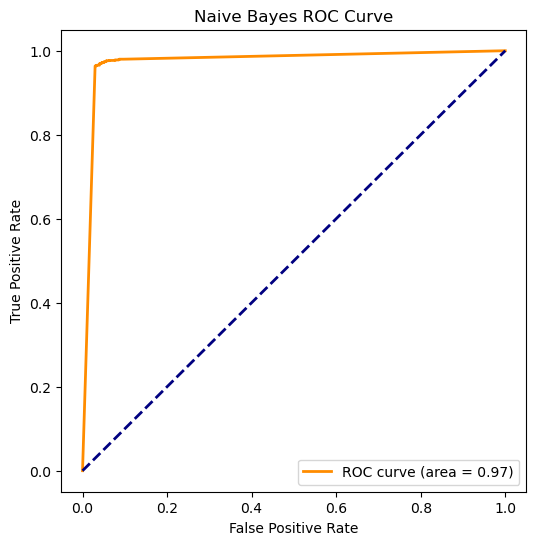

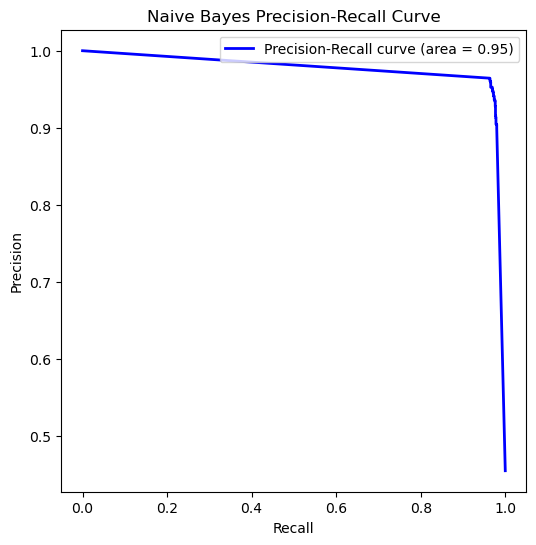

In [25]:
from sklearn.naive_bayes import GaussianNB

# Train Naive Bayes model
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Predictions
y_pred = nb_classifier.predict(X_test)
y_prob = nb_classifier.predict_proba(X_test)[:, 1]

print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Log Loss:", log_loss(y_test, y_prob))
print("--------------------------------------------------")


# Confusion Matrix Visualization
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(nb_classifier, X_test, y_test, ax=ax, cmap="Blues", display_labels=["Class 0", "Class 1"])
ax.set_title("Naive Bayes Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Naive Bayes Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


KNN Results:
Accuracy: 0.8450742240215925
Precision: 0.8531468531468531
Recall: 0.7964391691394659
F1 Score: 0.8238182934315531
ROC AUC Score: 0.9001000381937304
Log Loss: 1.3968968047496184
--------------------------------------------------


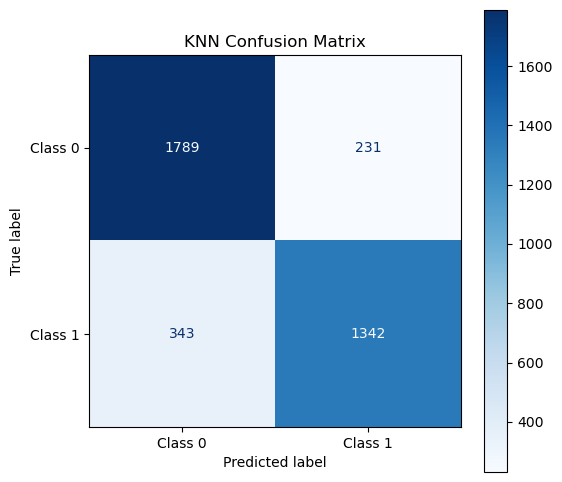

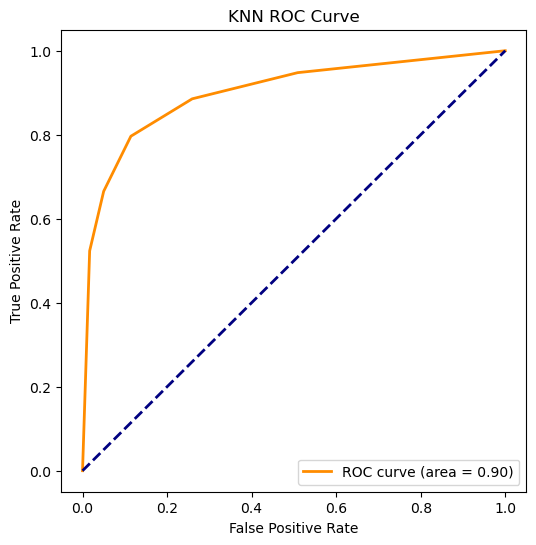

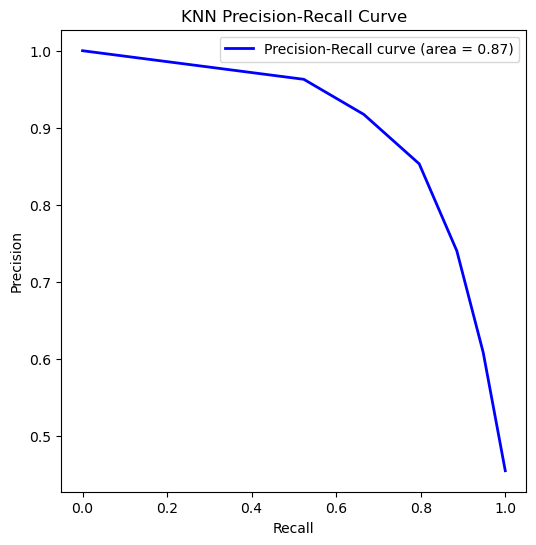

In [26]:
from sklearn.neighbors import KNeighborsClassifier

# Train KNN model
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)

# Predictions
y_pred = knn_classifier.predict(X_test)
y_prob = knn_classifier.predict_proba(X_test)[:, 1]

print("KNN Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Log Loss:", log_loss(y_test, y_prob))
print("--------------------------------------------------")


# Confusion Matrix Visualization
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(knn_classifier, X_test, y_test, ax=ax, cmap="Blues", display_labels=["Class 0", "Class 1"])
ax.set_title("KNN Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('KNN Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()




---

